# Group Project 3 - Group 19

| **S.no** 	| Team Member                         	|
|:--------:	|------------------------------	|
|     1    	| Carlee Allen|
|     2    	|  Harshit Jain 	|
|     3    	| Sunil Kamkar Sheshagiri           	|
|     4    	| Amritangshu Mukherjee        	|

------------------------------------------------------

## Load Libraries

In [3]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

___________

## Define Variables

In [4]:
runtime_limit = 3600 # in seconds
#m = 50
M = 100 # large number
list_of_k = [5,10,15,20,25,30,35,40,45,50] # list of k values how many variables to select
n = 10 # number of folds for cross validation


________________

## Data Load

In [5]:
data_train = pd.read_csv('training_data.csv')
data_test = pd.read_csv('test_data.csv')
data_test.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,-0.339223,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,-0.261740,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,-2.544812,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,-1.571784,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,-0.646661,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [6]:
#xtest in numpy
xtest = data_test.iloc[:,1:].to_numpy()
xtest.shape

#xtrain in numpy
xtrain = data_train.iloc[:,1:].to_numpy()
xtrain.shape

#ytrain in numpy
ytrain = data_train.iloc[:,0].to_numpy()
ytrain.shape

#ytest in numpy
ytest = data_test.iloc[:,0].to_numpy()
ytest.shape

#store shapes of xrain, ytrain, xtest, ytest in df
df = pd.DataFrame(columns = ['xtrain','ytrain','xtest','ytest'])
df.loc[0] = [xtrain.shape, ytrain.shape, xtest.shape, ytest.shape]
df


,xtrain,ytrain,xtest,ytest
0,"(250, 50)","(250,)","(50, 50)","(50,)"


In [7]:
#m is number of x columns in training data
m = xtrain.shape[1]
m

50

_________________

## Question 1,2

In [8]:
#function to calculate beta coefficient given xtrain, ytrain, k
def calculation_of_beta(X, y, k):
    #X: n*p
    #y: n*1
    #k: [5,10,15,20,25,30,35,40,45,50]
    #(m+1) values of 𝛽 and the m values of z
    #b is the coefficients of the linear regression, z is the binary variable
    # formula for quadratic program 
    Q = np.zeros((2*m+1, 2*m+1))
    A = np.zeros((2*m+1, 2*m+1))
    b = np.array([0]*(2*m+1))

    #b vector to be a (2m+1) x 1 vector.
    b[-1] = k

    #A matrix to be a (2m+1) x (2m+1) matrix.
    A[:,0] = 0
    A[0:m, 1:m+1] = np.diag(np.ones(m))
    A[0:m, m+1:2*m+1] = np.diag(np.ones(m))*M
    A[m:2*m, 1:m+1] = np.diag(np.ones(m))
    A[m:2*m, m+1:2*m+1] = np.diag(np.ones(m))*(-M)
    A[2*m:2*m+1, m+1:2*m+1] = [1]*m

    #B_t(X_t*𝑋)B + (−2*Y_t*𝑋)B
    #Q matrix : X_t*𝑋 to be a (2m+1) x (2m+1) matrix where the upper left corner of the matrix is equal to XTX, and all other values are zero.
    Xconstant = np.insert(X, 0, [1] * len(X), axis=1)
    Q[0:m+1, 0:m+1] = np.transpose(Xconstant) @ Xconstant
    
    #c matrix : 2*Y_t*X We also need the linear term of the objective to be a (2m+1) x 1 vector where the first (m+1) components are -2yTX, and the rest are zeros.
    constant_arr = np.zeros((len(Xconstant), 2*m+1))
    constant_arr[0:len(Xconstant), 0:m+1] = Xconstant
    c = -2 * np.transpose(y) @ constant_arr

    #(m+1) values of 𝛽 and the m values of z
    #sense to be a (2m+1) x 1 vector.
    sense = np.array(['>']*m + ['<']*m +['<'])
    #vtype to be a (2m+1) x 1 vector.
    vtype=['C']*m+['C']+['B']*m
    #lower bound lb to be a (2m+1) x 1 vector In order to allow your 𝛽s to be negative or positive you must set the lb value of your model to be -M for the appropriate decision variables.
    lb = np.array([np.NINF] + [-M]*m + [0]*m)

    #running the model-------------------------------------------------------------------------------
    biMod = gp.Model()
    biMod_x = biMod.addMVar(len(Q),lb=lb,vtype=vtype)
    biMod.addMConstrs(A, biMod_x, sense, b)
    biMod.setMObjective(Q,c,0,sense=gp.GRB.MINIMIZE)
    biMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    biMod.Params.TimeLimit = runtime_limit
    biMod.optimize()
    
    coeficient = biMod_x.x
    value_coeff=coeficient[0:m+1]
    return value_coeff

In [9]:
calculation_of_beta(xtrain, ytrain , 40)

Using license file /Users/amritangshumukherjee/gurobi.lic
Academic license - for non-commercial use only - expires 2023-08-17


array([ 0.95459795,  0.        ,  0.11960997,  0.38197755,  0.38759598,
        0.        , -0.21327861,  0.57385268,  0.        , -2.78544608,
        0.60362132,  0.        , -0.41859309,  0.54486423,  0.33755364,
       -0.35817924, -0.21411056,  0.43553158,  0.6563841 ,  0.55925392,
        0.91613607,  0.19474857, -0.4428736 , -1.17070892,  0.77931416,
        0.        , -1.4964771 ,  0.        , -0.36489672,  0.38083221,
        0.        , -0.20029246,  0.79033368,  0.        ,  1.29672001,
       -0.51357219,  0.2407427 ,  0.19299609, -0.15701282, -1.10031968,
        0.40954511, -0.67796522,  0.33893476, -0.47957257,  0.        ,
        1.84890305,  0.        ,  1.0134497 ,  0.25087589,  0.51752253,
       -0.21864319])

In [10]:
#function to calculate the least square error given matrix of coeff, X, y
def least_square_error(coeff, X, y):
    #coeff: m+1*1
    #X: n*p
    #y: n*1
    #formula for least square error
    Xconstant = np.insert(X, 0, [1] * len(X), axis=1)
    yhat = Xconstant @ coeff
    return np.sum((y - yhat)**2)

In [11]:
least_square_error(calculation_of_beta(xtrain, ytrain, 40), xtrain, ytrain)

524.3706415803392

In [12]:
def cross_validation(xtrain, ytrain, k):
    #xtrain: n*p
    #ytrain: n*1
    #k: [5,10,15,20,25,30,35,40,45,50]
    #formula for cross validation
    #randomly shuffle your data and split it into 10 folds
    index = np.arange(xtrain.shape[0])
    np.random.shuffle(index)
    xtrain = xtrain[index]
    ytrain = ytrain[index]
    #split data into 10 folds
    xtrain_split = np.array_split(xtrain, n)
    ytrain_split = np.array_split(ytrain, n)
    df = pd.DataFrame(columns = ['coefficients','sse'])
    #calculate the least square error of each fold
    least_square_error_list = []
    for i in range(n):
        xtrain_cv = np.concatenate(xtrain_split[:i] + xtrain_split[i+1:])
        ytrain_cv = np.concatenate(ytrain_split[:i] + ytrain_split[i+1:])
        xtest_cv = xtrain_split[i]
        ytest_cv = ytrain_split[i]
        beta = calculation_of_beta(xtrain_cv, ytrain_cv, k)
        least_square_error_list.append(least_square_error(beta, xtest_cv, ytest_cv))
        df.loc[len(df)] = [beta,least_square_error_list[i]]
    #calculate the average least square error
    sse_sum = np.sum(least_square_error_list)
    average_least_square_error = np.mean(least_square_error_list)
    return df, sse_sum


In [13]:
cross_validation(xtrain, ytrain, 5)

(                                        coefficients         sse
 0  [1.0402840932179527, 0.0, 0.0, 0.0, 0.0, 0.0, ...   84.346224
 1  [1.124939815071779, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   64.825504
 2  [1.0510194780426658, 0.0, 0.0, 0.0, 0.0, 0.0, ...   36.054376
 3  [1.0376260759453997, 0.0, 0.0, 0.0, 0.0, 0.0, ...  108.534169
 4  [1.0899441233345692, 0.0, 0.0, 0.0, 0.0, 0.0, ...  124.435678
 5  [1.0004343323028435, 0.0, 0.0, 0.0, 0.0, 0.0, ...  121.126727
 6  [1.0612806685573943, 0.0, 0.0, 0.0, 0.0, 0.0, ...   97.945869
 7  [1.0207981102766035, 0.0, 0.0, 0.0, 0.0, 0.0, ...   88.336211
 8  [1.060311196214241, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   47.209461
 9  [1.0522889229377603, 0.0, 0.0, 0.0, 0.0, 0.0, ...  147.529661,
 920.3438814863473)

In [18]:
#determine best value of k by testing k in list_of_k print best k and sse and mse

#list_of_k = [5,10]
list_of_k = [5,10,15,20,25,30,35,40,45,50]
def best_k(xtrain, ytrain, list_of_k):
    #xtrain: n*p
    #ytrain: n*1
    #list_of_k: [5,10,15,20,25,30,35,40,45,50]

    sse_list = []
    mse_list = []
    #df to store k value and best coefficeint
    temp_df = pd.DataFrame(columns = ['k','coefficients','sse','non zero coefficients'])
    for k in list_of_k:
        df, sse = cross_validation(xtrain, ytrain, k)
        sse_list.append(sse)
        mse_list.append(sse/len(xtrain))

        #best set of coefficient in df
        best_coeff = df.loc[df['sse'].idxmin()]['coefficients']
        temp_df.loc[len(temp_df)] = [k, best_coeff, sse, np.count_nonzero(best_coeff)]

    k_select = list_of_k[sse_list.index(min(sse_list))]
    best_sse = min(sse_list)
    return k_select, best_sse,temp_df

#check if file hold_data.csv exist, if yes then ask for user input yes else run the code
if os.path.isfile('hold_data.csv'):
    print('hold_data.csv exist')
    print('Do you want to run the code?')
    user_input = input('yes or no')
    if user_input == 'yes':
        k_select, best_sse, temp_df = best_k(xtrain, ytrain, list_of_k)
        print('best k is', k_select)
        print('best sse is', best_sse)
        temp_df.to_csv('hold_data.csv')
        
    else:
        temp_df=pd.read_csv('hold_data.csv')
        k_select = temp_df.loc[temp_df['sse'].idxmin()]['k']
        print('best k is', temp_df.loc[temp_df['sse'].idxmin()]['k'])
        print('best sse is', temp_df.loc[temp_df['sse'].idxmin()]['sse'])
else:
    k_select, best_sse, temp_df = best_k(xtrain, ytrain, list_of_k)
    print('best k is', k_select)
    print('best sse is', best_sse)
    temp_df.to_csv('hold_data.csv')

miqp_perf=temp_df
miqp_perf

hold_data.csv exist
Do you want to run the code?
best k is 10
best sse is 732.7652362429698


,Unnamed: 0,k,coefficients,sse,non zero coefficients
0,0,5,[ 1.0515476 0. 0. 0. ...,904.720295,6
1,1,10,[ 1.04911777 0. 0. 0. ...,732.765236,11
2,2,15,[ 0.97472893 0. 0. 0. ...,815.112243,16
3,3,20,[ 0.97583595 0. 0. 0. ...,767.516963,21
4,4,25,[ 0.97496661 0. 0. 0. ...,842.476040,26
5,5,30,[ 1.00418719 0. 0. 0.150896...,830.152190,31
6,6,35,[ 0.95228784 -0.33456727 0. 0. ...,857.525990,36
7,7,40,[ 0.97166612 0. 0.22344874 0.507527...,815.700371,41
8,8,45,[ 1.02498121 -0.11957 0.16485703 0.367770...,880.390889,44
9,9,50,[ 0.91248791 0.00640476 0.139828 0.263579...,880.791201,51


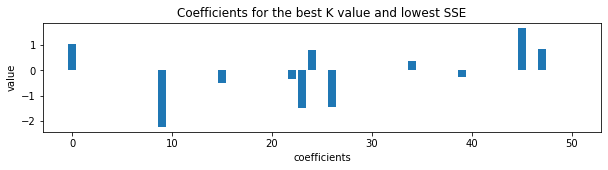

In [15]:
coeff=temp_df.loc[temp_df['sse'].idxmin()]['coefficients']

#check if \n prsent in coeff
if '\n' in coeff:
    coeff = coeff.replace('\n', '')
    coeff = coeff.replace('[', '')
    coeff = coeff.replace(']', '')
    coeff = coeff.split()
    coeff = [float(i) for i in coeff]
    coeff = np.array(coeff)

plt.figure(figsize=(10,2))
plt.bar(range(len(coeff)), coeff)
plt.title('Coefficients for the best K value and lowest SSE')
plt.xlabel('coefficients')
plt.ylabel('value')
plt.show()

________
## Question 3

In [16]:
#fit model on entire train data with best k
best_coefficient=calculation_of_beta(xtrain, ytrain, k_select)

#use the best coefficient to predict yhat on test data
Xconstant = np.insert(xtest, 0, [1] * len(xtest), axis=1)
yhat = Xconstant @ best_coefficient

#print yhat
print(yhat)

#calculate sse on test data
sse_test_MIQP = np.sum((ytest - yhat)**2)
print('The sse on test data is', sse_test_MIQP)

#calculate r2 on test data
r2_test_MIQP = 1 - sse_test_MIQP/np.sum((ytest - np.mean(ytest))**2)
print('The r2 on test data is', r2_test_MIQP)


[ 6.17985878  5.09524299  3.28559532  3.75848539 -0.33297526 -5.14273683
 -3.14454357 -1.23806288  1.38511093 -0.44173854 -1.69500225  2.73035027
  0.74744903 -0.97192232 -0.68681528  8.04522381 -7.94698471  3.89063974
 -4.58142919 -3.21992082 -2.16211454  3.21686318 -3.19810533  0.19740731
 -2.35988844 -0.41999885 -1.9125216  -3.32418587 -3.14170972 -3.55379324
 -1.80842543 -0.37134301  1.8670808   5.04927886 -1.80005614  3.09427675
  4.38154309  2.6988627   1.6132886   5.97584637 -1.1973583   5.2232542
 -5.84899891 -1.14461528  4.51802998  4.18774866  4.12046008  0.61483809
  1.95723246 -1.54904383]
The sse on test data is 116.8271982276262
The r2 on test data is 0.8586682910020946


__________________

## Question 4

Use scikit learn to do 10-fold cross validation on the training set to pick 𝜆. Once you find the best value of 𝜆, fit a LASSO model to the entire training set using that value of 𝜆. With the 𝛽s you find in that LASSO model make a prediction of the y values in the test set.

In [17]:
#Use scikit learn to do 10-fold cross validation on the training set to pick lambda

def cv_sse_score_lasso(X,y,alpha):
    #X: n*p
    #y: n*1
    #alpha: [0.0001,0.001,0.01,0.1,1,10,100,1000]
    #formula for cross validation
    sse = 0
    sse_sum=[]
    sse_list=[]
    kf = KFold(n_splits=n)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        yhat = lasso.predict(X_test)
        sse = np.sum((y_test - yhat)**2)
        sse_list.append(sse)
    sse_sum = np.sum(sse_list)
    average_least_square_error = np.mean(sse_list)
    return sse_sum


In [19]:
#normalize the data using standard scaler
import sklearn as sk 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [21]:
cv_sse_score_lasso(xtrain, ytrain, 0.01)

779.4268169845167

In [22]:
#best alpha using 10-fold cross validation on training set using cv_accuracy_score_lasso
list_of_alpha = 10**np.linspace(3,-3,100)
def best_alpha(xtrain, ytrain, list_of_alpha):
    #xtrain: n*p
    #ytrain: n*1
    #list_of_alpha: 10**np.linspace(3,-3,100)
    sse_list = []
    #df to store alpha value and best coefficeint and sse
    temp_df = pd.DataFrame(columns = ['alpha','sse'])
    for alpha in list_of_alpha:
        sse = cv_sse_score_lasso(xtrain, ytrain, alpha)
        sse_list.append(sse)
        temp_df.loc[len(temp_df)] = [alpha ,sse]

    best_alpha = list_of_alpha[sse_list.index(min(sse_list))]
    best_sse = min(sse_list)
    return best_alpha, best_sse,temp_df

alpha_select,sse,lambda_perf=best_alpha(xtrain, ytrain, list_of_alpha)
print('The best alpha is', alpha_select, 'with sse', sse)
lambda_perf


The best alpha is 0.08697490026177834 with sse 698.6599401836846


,alpha,sse
0,1000.000000,4943.255428
1,869.749003,4943.255428
2,756.463328,4943.255428
3,657.933225,4943.255428
4,572.236766,4943.255428
...,...,...
95,0.001748,829.262092
96,0.001520,831.907798
97,0.001322,834.405489
98,0.001150,836.125828


In [21]:
#fit model on entire train data with best alpha
lasso = Lasso(alpha=alpha_select)
lasso.fit(xtrain, ytrain)
yhat = lasso.predict(xtest)

#print the first 10 yhat
print(yhat)

#calculate sse on test data
sse_test_lasso = np.sum((ytest - yhat)**2)
print('The sse on test data is', sse_test_lasso)

#calculate r2 on test data
r2_test_lasso = 1 - sse_test_lasso/np.sum((ytest - np.mean(ytest))**2)
print('The r2 on test data is', r2_test_lasso)

[ 6.07920695  4.91821176  3.22938558  3.57269902 -0.41887608 -4.95279151
 -2.82253586 -1.49669292  1.38204396 -0.24649558 -1.94669224  2.70686311
  0.64573778 -0.50742459 -0.31804099  7.38066696 -7.5512808   3.59346235
 -4.39515901 -2.98833238 -1.94391142  3.33048512 -2.42365248  1.13284388
 -2.53660637 -0.1548456  -1.62646119 -2.31765893 -3.4659375  -3.71779758
 -1.66893203 -0.07897655  1.40503668  5.45240041 -1.2039636   2.37264021
  4.74896634  3.12898857  1.55096086  5.85525208 -0.81404428  4.66488981
 -5.71830719 -1.21112084  4.25440206  4.09879276  3.83181804  0.61678184
  1.89303431 -1.02668652]
The sse on test data is 117.46879040592437
The r2 on test data is 0.8578921248317659


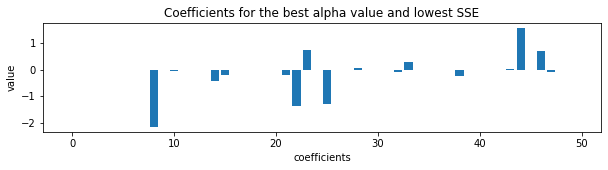

In [22]:
#plot the coefficients of lasso for best alpha
plt.figure(figsize=(10,2))
plt.bar(range(len(lasso.coef_)), lasso.coef_)
plt.title('Coefficients for the best alpha value and lowest SSE')
plt.xlabel('coefficients')
plt.ylabel('value')
plt.show()

____________________

## Question 5 

#### Compare Performace

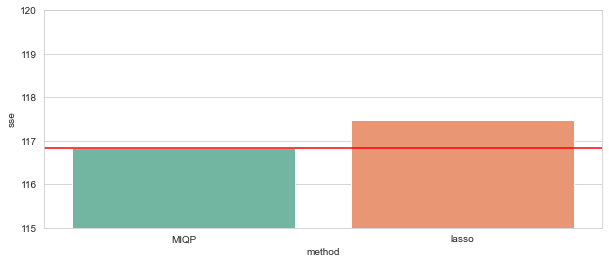

,method,sse,r2,number of non zero coefficients
0,MIQP,116.827198,0.858668,11
1,lasso,117.468790,0.857892,17


In [23]:
#compare performance of MIQP and lasso on test data
compare = pd.DataFrame(columns = ['method','sse','r2','number of non zero coefficients'])
compare.loc[len(compare)] = ['MIQP', sse_test_MIQP, r2_test_MIQP, len(best_coefficient[best_coefficient!=0])]
compare.loc[len(compare)] = ['lasso', sse_test_lasso, r2_test_lasso, len(lasso.coef_[lasso.coef_!=0])]


#plot BAR the performance of MIQP and lasso on test data sse
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.barplot(x='method', y='sse', data=compare, palette='Set2')
plt.axhline(y=sse_test_MIQP, color='r', linestyle='-')
plt.ylim(115,120)
plt.show()

compare



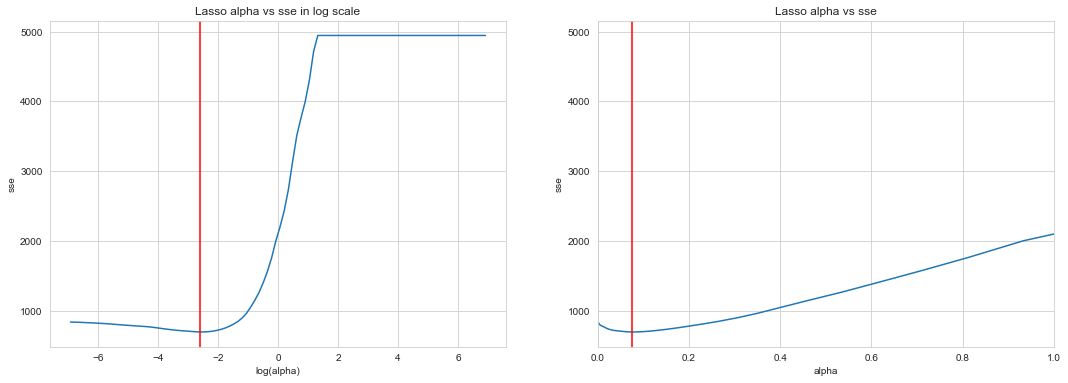

In [24]:
#show subplot of lasso alpha vs sse
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(np.log(lambda_perf['alpha']), lambda_perf['sse'])
ax[0].axvline(x=np.log(alpha_select), color='r')
ax[0].set_xlabel('log(alpha)')
ax[0].set_ylabel('sse')
ax[0].set_title('Lasso alpha vs sse in log scale')
ax[1].plot(lambda_perf['alpha'], lambda_perf['sse'])
ax[1].axvline(x=alpha_select, color='r')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('sse')
ax[1].set_title('Lasso alpha vs sse')
ax[1].set_xlim(0, 1)
plt.show()


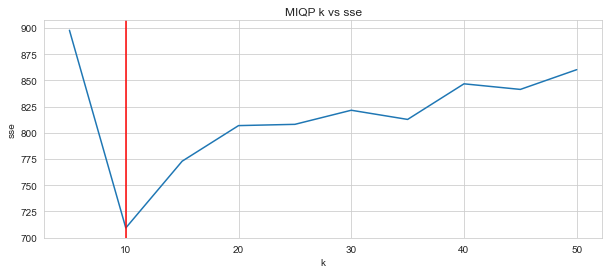

In [29]:
#plot miqp_perf k vs sse add title
plt.figure(figsize=(10,4))
#add title in plot
plt.title('MIQP k vs sse')
#add axis
plt.xlabel('k')
plt.ylabel('sse')
plt.plot(miqp_perf['k'], miqp_perf['sse'])
plt.axvline(x=k_select, color='r', linestyle='-')
plt.show()

<Figure size 720x720 with 0 Axes>

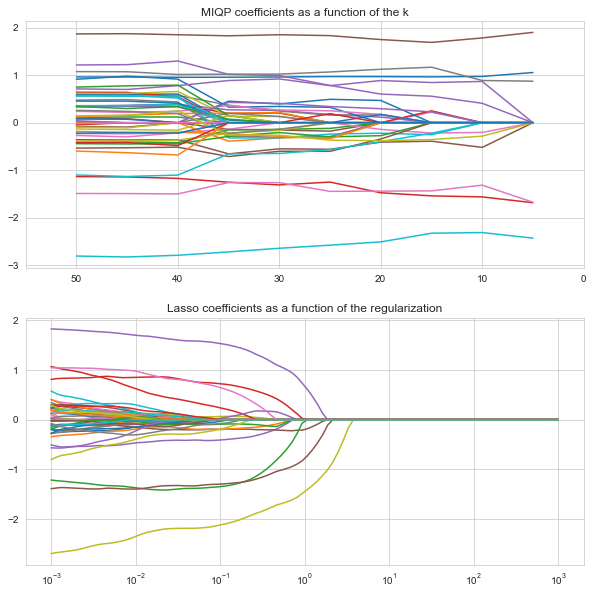

In [26]:
#plot miqp vs different k
list_of_k = [5,10,15,20,25,30,35,40,45,50]
coefficients_miqp = []
for k in list_of_k:
    coefs = calculation_of_beta(xtrain, ytrain, k)
    coefficients_miqp.append(coefs)
    
# Plot the coefficients learned for all of the alpha in lasso
coefficients_lasso = []
for alpha in list_of_alpha:
    model = Lasso(alpha)
    model.fit(xtrain, ytrain) # Fit the model
    coefficients_lasso.append(model.coef_)

#compare miqp and lasso in subplots
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(np.asarray(list_of_k), coefficients_miqp)
axs[0].set_xlim(55, 0)
axs[0].set_title('MIQP coefficients as a function of the k')
axs[1].plot(list_of_alpha, coefficients_lasso)
axs[1].set_xscale('log')
axs[1].set_title('Lasso coefficients as a function of the regularization')
plt.show()

<Figure size 720x720 with 0 Axes>

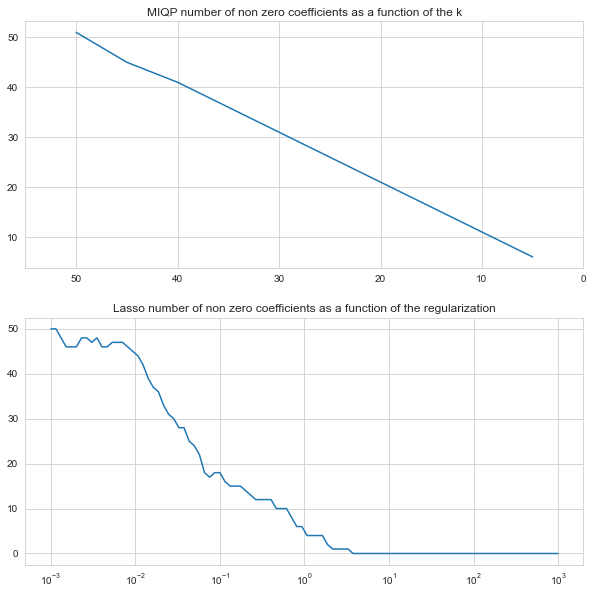

In [27]:
#subplots to compare number of non zero coefficients of miqp and lasso wrt to best k and best alpha
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(np.asarray(list_of_k), np.sum(np.abs(coefficients_miqp) > 1e-10, axis=1))
axs[0].set_xlim(55, 0)
axs[0].set_title('MIQP number of non zero coefficients as a function of the k')
axs[1].plot(list_of_alpha, np.sum(np.abs(coefficients_lasso) > 1e-10, axis=1))
axs[1].set_xscale('log')
axs[1].set_title('Lasso number of non zero coefficients as a function of the regularization')
plt.show()


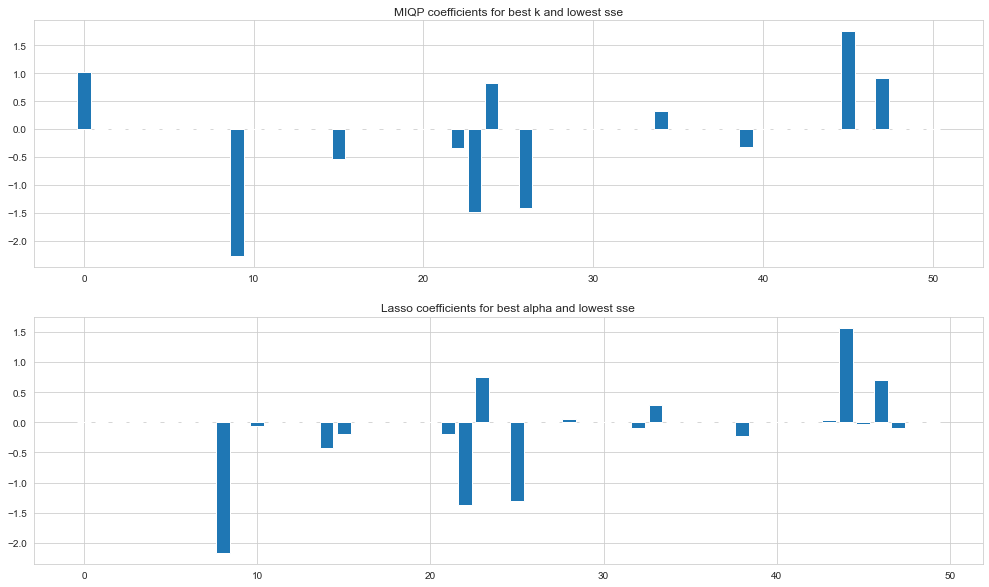

In [28]:
#subplots to compare coefficients of miqp and lasso wrt to best k and best alpha
fig, axs = plt.subplots(2, 1, figsize=(17, 10))
axs[0].bar(range(len(coeff)), coeff)
axs[0].set_title('MIQP coefficients for best k and lowest sse')
axs[1].bar(range(len(lasso.coef_)), lasso.coef_)
axs[1].set_title('Lasso coefficients for best alpha and lowest sse')
plt.show()


_____________